Importing dependencies: keras, sklearn.metrics, numpy, pandas and matplotlib.pyplot

In [77]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Defining necessary parameters for the model.

In [78]:
image_width = 250 
image_height = 250

# directories set as defined in cell 1

training_directory = 'data/train'
validation_directory = 'data/validate'
testing_directory = 'data/test'

# number of training images vary for each class. number of validation and testing images = 50 for each class
# Number of Epochs was chosen randomly:
# 40 would be sufficient since we have a small dataset
# batch size = 16 since we have a small dataset
number_training_imgs = 1038
number_validation_imgs = 200
epochs = 40
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
else:
    input_shape = (image_width, image_height, 3)

Building the CNN model: I use a sequential model having three convolution layers with ReLU activation followed by max-pooling layers. These layers are followed by two fully connected layers having ReLU and softmax activation.

In [79]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape=input_shape))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(32, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# the model so far outputs 3D feature maps (height, width, features)

classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
classifier.add(Dense(64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(4))
classifier.add(Activation('softmax'))

classifier.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
activation_136 (Activation)  (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_137 (Activation)  (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 59, 59, 64)        18496     
__________

I used data-augmentation since I had a few training examples. This helps prevent overfitting since the model never sees the exact same image twice. I used keras.preprocessing.image.ImageDataGenerator class to do this.

In [80]:
# Augmentation configuration used for training

trainingDataGenerator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Augmentation configuration used for validating and testing: only rescaling

validationDataGenerator = ImageDataGenerator(rescale=1. / 255)
testDataGenerator = ImageDataGenerator(rescale=1./255)

Training the model.

In [81]:
training_generator = trainingDataGenerator.flow_from_directory(
    training_directory,
    target_size=(image_width, image_height), # all images resized to 250 x 250
    batch_size=batch_size,
    class_mode='categorical') # we need categorical labels for categorical_crossentropy loss

validation_generator = validationDataGenerator.flow_from_directory(
    validation_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

classifier.fit_generator(
    training_generator,
    steps_per_epoch=number_training_imgs // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=number_validation_imgs // batch_size)

classifier.save_weights('weights.h5') #save computed weights

Found 1038 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Epoch 1/40
64/64 [==============================] - 43s 672ms/step - loss: 1.2121 - acc: 0.4492 - val_loss: 0.8314 - val_acc: 0.7760
Epoch 2/40
64/64 [==============================] - 42s 664ms/step - loss: 0.8833 - acc: 0.6663 - val_loss: 0.7960 - val_acc: 0.8315
Epoch 3/40
64/64 [==============================] - 44s 691ms/step - loss: 0.8068 - acc: 0.7164 - val_loss: 0.5400 - val_acc: 0.8967
Epoch 4/40
64/64 [==============================] - 46s 714ms/step - loss: 0.6722 - acc: 0.7688 - val_loss: 0.9413 - val_acc: 0.7554
Epoch 5/40
64/64 [==============================] - 46s 716ms/step - loss: 0.6429 - acc: 0.7633 - val_loss: 0.4708 - val_acc: 0.8967
Epoch 6/40
64/64 [==============================] - 48s 754ms/step - loss: 0.5564 - acc: 0.8051 - val_loss: 0.4005 - val_acc: 0.9022
Epoch 7/40
64/64 [==============================] - 50s 784ms/step - loss: 0.6970 - acc: 0.7398 - val_loss: 0.5568 - va

Testing the fitted model and generating predicted labels + filenames to find out what got predicted for each testing image.

In [82]:
test_generator = testDataGenerator.flow_from_directory(
        testing_directory,
        target_size=(250, 250),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames #generate filenames
number_of_samples = len(filenames)

index=0

image, label = test_generator._get_batches_of_transformed_samples(np.array([index]))
image_name = test_generator.filenames[index]

test_generator.reset()

predict = classifier.predict_generator(test_generator,steps = number_of_samples)
predicted_class_indices=np.argmax(predict,axis=1) # predicted_class_indices contains predicted labels(0,1,2,3)

labels = (training_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

Found 200 images belonging to 4 classes.


Generating the confusion matrix. 

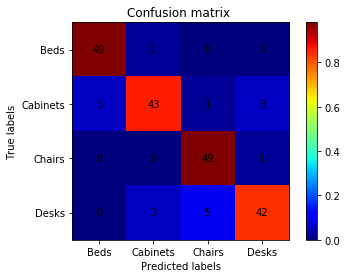

In [83]:
y_true = np.array([0] * 50 + [1] * 50 + [2] * 50 + [3] * 50) # since we have 50 test images belonging to each class
y_pred = predicted_class_indices
con_mat = confusion_matrix(y_true, y_pred)

norm_conf = []

for i in con_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = con_mat.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(con_mat[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')


cb = fig.colorbar(res)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix ')
plt.xticks(np.arange(0,4), ['Beds', 'Cabinets', 'Chairs', 'Desks'])
plt.yticks(np.arange(0,4), ['Beds', 'Cabinets', 'Chairs', 'Desks'])
plt.savefig('confusion_matrix.png', format='png')
plt.show()

Here I output the predicted results for each image into a CSV file.

In [84]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)
